## Scaling laws for LLM (Chinchilla + dependency on Inference tokens)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

### Based on Chinchilla third law and Andrej Karpathy calculations

https://github.com/karpathy/nanoGPT/blob/master/scaling_laws.ipynb

1. Построим зависимости loss'а от количества токенов (D) на обучении и размера модели (N).
2. Построим зависимость компьюта (C) от N и D как C = 6ND.
4. Учтем компьют на инференсе как C_inf = 2ND.

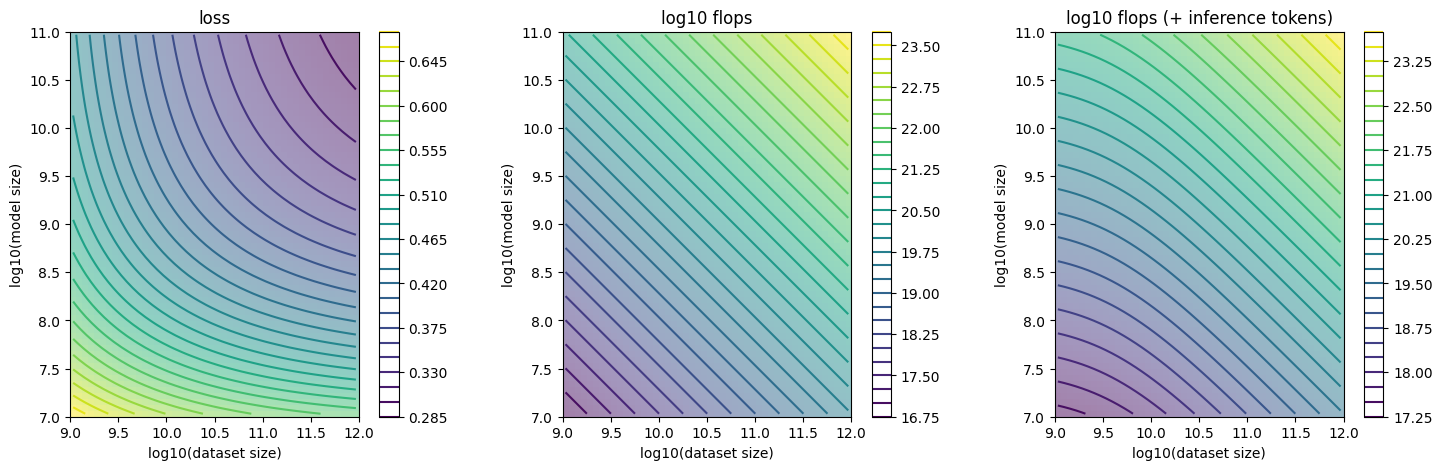

In [53]:
def L(N, D):
    E = 1.69
    A = 406.4
    B = 410.7
    alpha = 0.336
    beta = 0.283

    res = A / (N ** alpha) + B / (D ** beta) + E
        
    return res

ns = 10 ** np.arange(7, 11, step=2**-4) # model sizes from 10M to 100B
ds_tr = 10 ** np.arange(9, 12, step=2**-4) # number of tokens on training from 1B to 1T
ds_inf = 10e9 # number os tokens on inference

plt.figure(figsize=(18, 5))
plt.subplot(131)

# create a 2D countour plot of loss L as a function of model size and dataset size in ns,ds

loss2d = np.log10(np.array([[L(n, d) for d in ds_tr] for n in ns]))
plt.imshow(loss2d, extent=[9, 12, 7, 11], origin='lower', alpha=0.5)
plt.contour(loss2d, levels=30, extent=[9, 12, 7, 11], origin='lower')
plt.xlabel('log10(dataset size)')
plt.ylabel('log10(model size)')
plt.title('loss')
plt.colorbar()

# plot the compute for each point, which is a deterministic function: flops = 6*N*D

plt.subplot(132)
compute2d = np.log10(np.array([[6*n*d  for d in ds_tr] for n in ns]))
plt.imshow(compute2d, extent=[9, 12, 7, 11], origin='lower', alpha=0.5)
plt.contour(compute2d, levels=30, extent=[9, 12, 7, 11], origin='lower')
plt.xlabel('log10(dataset size)')
plt.ylabel('log10(model size)')
plt.title('log10 flops')
plt.colorbar()

# plot the compute for each point, which is a deterministic function: flops = 6*N*D
# + inference flops_inf = 2*N*D

plt.subplot(133)
compute2d = np.log10(np.array([[6*n*d + 2*n*ds_inf for d in ds_tr] for n in ns]))

plt.imshow(compute2d, extent=[9, 12, 7, 11], origin='lower', alpha=0.5)
plt.contour(compute2d, levels=30, extent=[9, 12, 7, 11], origin='lower')
plt.xlabel('log10(dataset size)')
plt.ylabel('log10(model size)')
plt.title('log10 flops (+ inference tokens)')
plt.colorbar()

Теперь при фиксированном компьюте и с ограничением на loss мы можем посчитать ряд оптимальных параметров для размера модели и объема данных в токенах. 

In [86]:
#Компьют A100_day = 3.12TFLOPs * 0.4 (реальная утилизация) / 60/60/24

a100_day = 3.12e14 * 0.4 / 60/60/24

print('A100 FLOPs per day:', '{:.2f}'.format(a100_day))

# cs = np.arange(a100_day * 100, a100_day*1000*365, step=a100_day*50)
cs = 10 ** np.arange(17, 26, step=2**-8)

d_inf = 1e10 #10B токенов на инференсе

models = []
for c in cs:
    ns = np.arange(1e6, 1e12, step=3e8)
    ds = np.array([])

    for n in ns:
        if c <= 2*n*d_inf:
            continue
        ds = np.append(ds, (c - 2*n*d_inf) / (6 * n))

    print(len(ns), len(ds))

    losses = np.array([])
    
    losses = L(ns, ds)
    best = np.argmin(losses)
    models.append((c, ns[best], ds[best]))

print(len(models))

A100 FLOPs per day: 1444444444.44
3334 1


IndexError: index 3333 is out of bounds for axis 0 with size 1

In [55]:
L(ns[0], ds[0])

/tmp/ipykernel_3433/3406924609.py:8: RuntimeWarning: invalid value encountered in scalar power
  res = A / (N ** alpha) + B / (D ** beta) + E


nan